# Display morphology population features

Copyright (c) 2025 Open Brain Institute

Authors: Michael W. Reimann

last modified: 01.2025

## Summary
This notebook analyzes a list of neuron morphology files. It extracts neurite or morphology features from them and displays the distribution of their values as a histogram. 
For details, see the [README](README.md).

In [1]:
import pandas
import zipfile
import neurom
import numpy
import os
import requests

from ipywidgets import widgets
from matplotlib import pyplot as plt
from io import BytesIO

# Got this to work. But it reads the whole file at once into memory.
lnk = "https://drive.usercontent.google.com/download?id=1U6gTWtHvqOQo17UI00F5yqJQ_bU3mdGO&export=download&authuser=0"
try:
    resp = requests.get(lnk)
    resp.raise_for_status()  # Check for HTTP errors
except requests.exceptions.RequestException as e:
    print(f"Error downloading file: {e}")
    raise
finally:
    resp.close()

try:
    f_zip = zipfile.ZipFile(BytesIO(resp.content))
except zipfile.BadZipFile as e:
    print(f"Zip archive appears to be malformed: {e}")
    raise

# Or just download the file and place it here.
## f_zip = zipfile.ZipFile("download.zip")

# The "metadata" is for now just dummy data I added.
contents = pandas.read_json(f_zip.open("metadata.json"))

nbins = widgets.IntSlider(10, 5, 100, 1)
        
def morphology_from_zip(z_obj, fn):
    with z_obj.open(fn, "r") as fid:
        m_str = fid.read().decode("UTF-8")
    try:
        m = neurom.load_morphology(m_str, reader="asc")
    except Exception as e:
        print("Trouble with " + fn + ": " + str(e))
        return None
    return m

contents = contents[contents["_filename"].apply(lambda _x: os.path.splitext(_x)[1] == ".asc")]
contents["_morphology"] = contents["_filename"].apply(lambda _x: morphology_from_zip(f_zip, _x))
contents = contents[contents["_morphology"].apply(lambda _x: _x is not None)]
contents.head()

Trouble with /r160127_0101_04.asc: 
/var/folders/py/wqmt8l2s5zb8fhrxbd_b258w0000gn/T/neurom-w18yh9ba370a157d-4b79-43d7-8a42-a783f6bee310.asc:432:error

A soma is already defined


,name,_filename,m-type,species,_morphology
0,AA0052,/AA0052.asc,SO_OLM,mus musculus,Morphology <soma: SomaSimpleContour(array([[8....
3,AA0053,/AA0053.asc,SO_OLM,mus musculus,Morphology <soma: SomaSimpleContour(array([[8....
6,AA0123,/AA0123.asc,SP_PVBC,rattus norvegicus,Morphology <soma: SomaSimpleContour(array([[8....
9,AA0124,/AA0124.asc,SO_OLM,rattus norvegicus,Morphology <soma: SomaSimpleContour(array([[8....
12,AA0159,/AA0159.asc,SO_OLM,mus musculus,Morphology <soma: SomaSimpleContour(array([[9....


Helper functions

In [2]:
def lookup(tp_feature, str_feature):
    def inner_func(obj, row, **kwargs):
        vals = neurom.features.get(str_feature, obj)
        if not hasattr(vals, "__iter__"):
                vals = [vals]
        ret = pandas.DataFrame({"value": vals})
        for idx in row.index:
            if not idx.startswith("_"): ret[idx] = row[idx]
        for k, v in kwargs.items(): ret[k] = v
        return ret
    
    def func(row):
        m = row["_morphology"]
        if tp_feature == 1:
            return inner_func(m, row)
        out = []
        for _nrt in m.neurites:
            out.append(inner_func(_nrt, row, neurite_type=str(_nrt.type)))
        return pandas.concat(out, axis=0)
    return func

def histogram_series(data, **kwargs):
    vals, bin_c = numpy.histogram(data, **kwargs)
    return pandas.Series(vals, index=0.5 * (bin_c[:-1] + bin_c[1:]))

Select the morphology feature to display from the dropdown menu.

In [3]:
function = widgets.Dropdown(
    options=
    [(k, (0, k)) for k, v in neurom.features._NEURITE_FEATURES.items()] +
    [(k, (1, k)) for k, v in neurom.features._MORPHOLOGY_FEATURES.items()], 
    description='Feature')
display(function)

Dropdown(description='Feature', options=(('number_of_segments', (0, 'number_of_segments')), ('number_of_sectio…

Select from the dropdown menus by which parameter to group the data (or "None" for no grouping).

Select with the slider the number of bins to show.

In [4]:
data_df = pandas.concat(contents.apply(lookup(*function.value), axis=1).values, axis=0)
data_df["None"] = "None"
grouper = widgets.Dropdown(
    options=[_col for _col in data_df.columns if _col != "value"],
    description="Grouped by"
)
display(grouper)
display(nbins)

Dropdown(description='Grouped by', options=('name', 'm-type', 'species', 'neurite_type', 'None'), value='name'…

IntSlider(value=10, min=5)

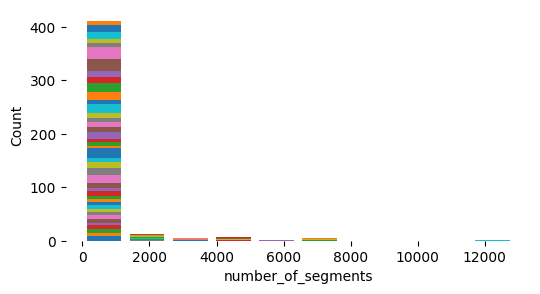

In [5]:
span = data_df["value"].max() - data_df["value"].min()
bins = numpy.linspace(data_df["value"].min(), data_df["value"].max() + 1E-9 * span, nbins.value + 1)
w = numpy.mean(numpy.diff(bins)) * 0.8
hist_df = data_df.groupby(grouper.value)["value"].apply(histogram_series, bins=bins).unstack(grouper.value)

fig = plt.figure(figsize=(6, 3))
ax = fig.gca()
ax.set_frame_on(False)

bot = numpy.zeros(len(hist_df))
for col in hist_df.columns:
    ax.bar(hist_df.index, hist_df[col].values, bottom=bot, label=col, width=w)
    bot += hist_df[col].values
ax.set_xlabel(function.value[1])
ax.set_ylabel("Count")
if len(hist_df.columns) < 10:
    plt.legend()